c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.057573, Val Loss: 0.001264
Epoch 2/50, Train Loss: 0.005354, Val Loss: 0.001594
Epoch 3/50, Train Loss: 0.003518, Val Loss: 0.001363
Epoch 4/50, Train Loss: 0.002794, Val Loss: 0.002283
Epoch 5/50, Train Loss: 0.001945, Val Loss: 0.001312
Epoch 6/50, Train Loss: 0.001544, Val Loss: 0.001725
Epoch 7/50, Train Loss: 0.001170, Val Loss: 0.000443
Epoch 8/50, Train Loss: 0.001056, Val Loss: 0.001436
Epoch 9/50, Train Loss: 0.000883, Val Loss: 0.001244
Epoch 10/50, Train Loss: 0.000788, Val Loss: 0.001621
Epoch 11/50, Train Loss: 0.000736, Val Loss: 0.000413
Epoch 12/50, Train Loss: 0.000524, Val Loss: 0.000405
Epoch 13/50, Train Loss: 0.000555, Val Loss: 0.000819
Epoch 14/50, Train Loss: 0.000512, Val Loss: 0.000486
Epoch 15/50, Train Loss: 0.000476, Val Loss: 0.000296
Epoch 16/50, Train Loss: 0.000386, Val Loss: 0.000604
Epoch 17/50, Train Loss: 0.000366, Val Loss: 0.000362
Epoch 18/50, Train Loss: 0.000319, Val Loss: 0.000394
Epoch 19/50, Train Loss: 0.000325, Va

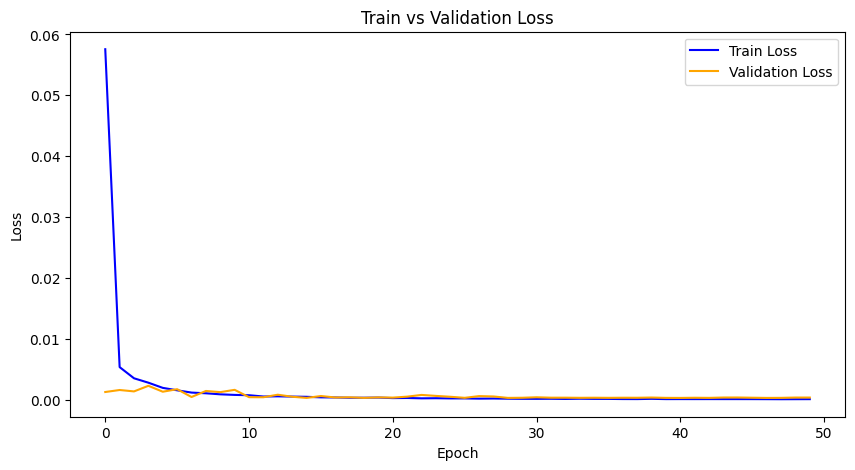

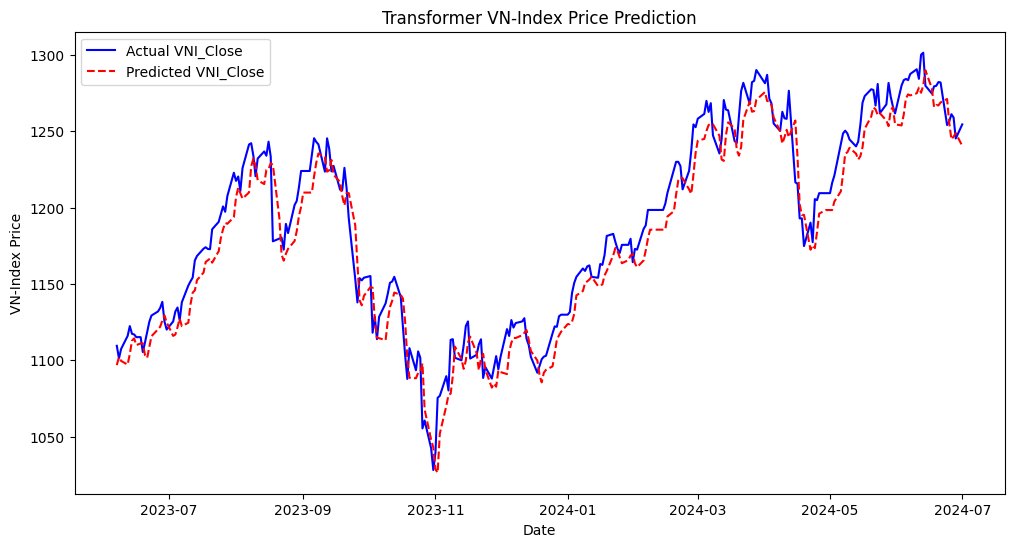

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_base.csv")

# Chuyển đổi cột Date thành datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = 'VNI_Close price'
feature_cols = [col for col in df.columns if col != target_col]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Chia tập dữ liệu
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Tạo DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Lấy vector cuối cùng để dự đoán
        out = self.fc(x)
        return out.squeeze()

# Khởi tạo mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

train_losses = []
val_losses = []

# Huấn luyện mô hình
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# Lưu mô hình
torch.save(model.state_dict(), "transformer_base.pth")
print("✅ Training hoàn tất! Mô hình đã được lưu.")

# Vẽ biểu đồ Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# Dự đoán trên tập test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

# Chuyển về giá trị gốc
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("Transformer VN-Index Price Prediction")
plt.show()


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Test MAE: 13.79
Test MSE: 265.83
Test RMSE: 16.30


             Actual    Predicted      Error
Date                                       
2024-09-23  1268.48  1263.992676   4.487324
2024-09-24  1276.99  1248.572388  28.417612
2024-09-25  1287.48  1259.515869  27.964131
2024-09-26  1291.49  1273.755493  17.734507
2024-09-27  1290.92  1278.516968  12.403032


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


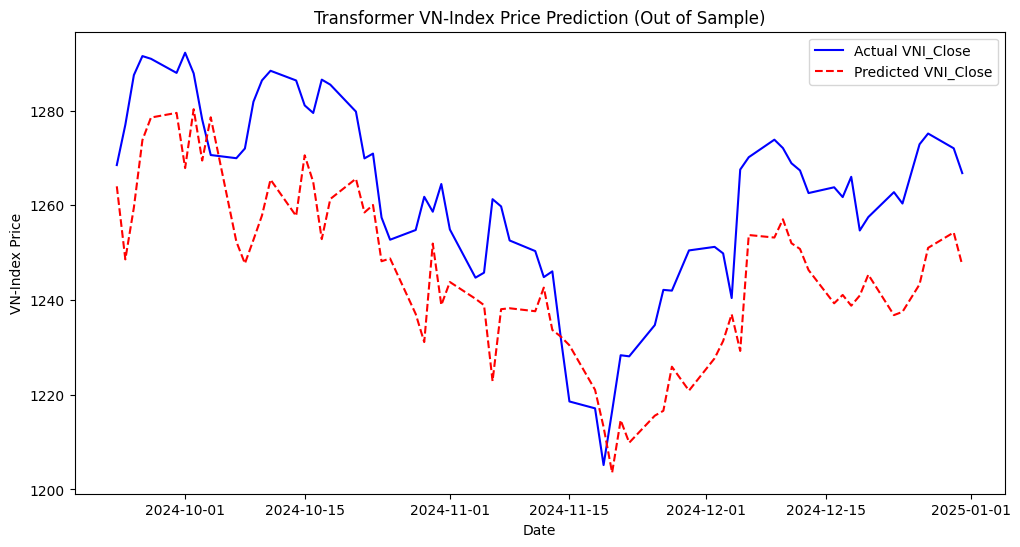

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dữ liệu OOS
file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_OOS_2.csv"
df_oos = pd.read_csv(file_path)

df_oos = df_oos[['Date','VNI_Volume','VNI_Close price','VNI_Open price', 'VNI_High price', 'VNI_Low price']]  # Chỉ giữ các cột đã dùng khi train
# Xóa cột không cần thiết
df_oos = df_oos.drop(columns=["Unnamed: 0"], errors="ignore")
# Chuyển đổi cột 'Date' thành datetime và đặt làm index
df_oos['Date'] = pd.to_datetime(df_oos['Date'], format="%m/%d/%Y")
df_oos.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = "VNI_Close price"
feature_cols = [col for col in df_oos.columns if col != target_col]

# Chuẩn hóa dữ liệu (scale riêng features và target)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df_oos_scaled = df_oos.copy()
df_oos_scaled[feature_cols] = scaler_features.fit_transform(df_oos[feature_cols])
df_oos_scaled[[target_col]] = scaler_target.fit_transform(df_oos[[target_col]])

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu OOS
seq_length = 60
X_oos, y_oos = create_sequences(df_oos_scaled, seq_length)

# -------------------- Định nghĩa Mô hình Transformer --------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=8, num_layers=2, dim_feedforward=256):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Lấy vector cuối cùng để dự đoán
        out = self.fc(x)
        return out.squeeze()

# -------------------- Load mô hình đã train --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_oos.shape[2]
model = TransformerModel(input_dim=input_size, seq_length=seq_length).to(device)

# Load trọng số đã huấn luyện
model.load_state_dict(torch.load("transformer_base.pth", map_location=device))
model.eval()

# -------------------- Dự đoán trên tập OOS --------------------
batch_size = 32
predictions_oos = []

with torch.no_grad():
    for i in range(0, len(X_oos), batch_size):
        batch_X = X_oos[i:i + batch_size].to(device)
        y_pred = model(batch_X).cpu().numpy()
        predictions_oos.extend(y_pred)

# Chuyển về giá trị gốc
predictions_oos = np.array(predictions_oos).reshape(-1, 1)
predictions_oos = scaler_target.inverse_transform(predictions_oos)

# Giá trị thực tế
actuals_oos = df_oos[target_col].iloc[-len(predictions_oos):].values.reshape(-1, 1)

# -------------------- Tạo DataFrame Kết quả --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
print(df_results.head())
# -------------------- Vẽ biểu đồ Actual vs Predicted OOS --------------------
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results["Actual"], label="Actual VNI_Close", color='blue')
plt.plot(df_results.index, df_results["Predicted"], label="Predicted VNI_Close", color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.title("Transformer VN-Index Price Prediction (Out of Sample)")
plt.legend()
plt.show()

In [10]:

# -------------------- Tính toán các chỉ số lỗi --------------------
mae = mean_absolute_error(actuals_oos, predictions_oos)
mse = mean_squared_error(actuals_oos, predictions_oos)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actuals_oos - predictions_oos) / actuals_oos)) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

# -------------------- Tạo DataFrame Kết quả --------------------
df_results = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],
    "Actual": actuals_oos.flatten(),
    "Predicted": predictions_oos.flatten(),
    "Error": np.abs(actuals_oos.flatten() - predictions_oos.flatten())
})
df_results.set_index("Date", inplace=True)
print(df_results.head())
df_results.to_csv("transformer_base_OOS_predictions.csv")


📊 MAE: 17.4220
📊 MSE: 381.2281
📊 RMSE: 19.5251
📊 MAPE: 1.38%
             Actual    Predicted      Error
Date                                       
2024-09-23  1268.48  1263.992676   4.487324
2024-09-24  1276.99  1248.572388  28.417612
2024-09-25  1287.48  1259.515869  27.964131
2024-09-26  1291.49  1273.755493  17.734507
2024-09-27  1290.92  1278.516968  12.403032


Baseline RMSE: 0.0137


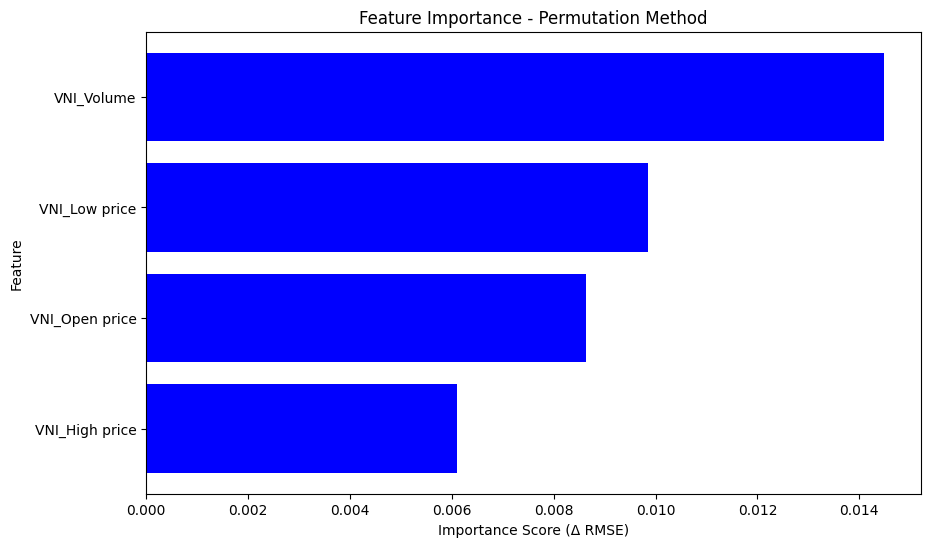

In [6]:
from sklearn.metrics import mean_squared_error
import copy

# Dự đoán ban đầu trên tập test (để lấy baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Tính Feature Importance bằng cách hoán đổi từng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # Xáo trộn feature thứ i

    # Dự đoán lại
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # Tính RMSE sau khi hoán đổi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature nào làm tăng RMSE nhiều là quan trọng hơn
    feature_importance[feature] = importance_score

# Sắp xếp theo độ quan trọng giảm dần
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Δ RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # Đảo ngược để feature quan trọng nhất ở trên cùng
plt.show()


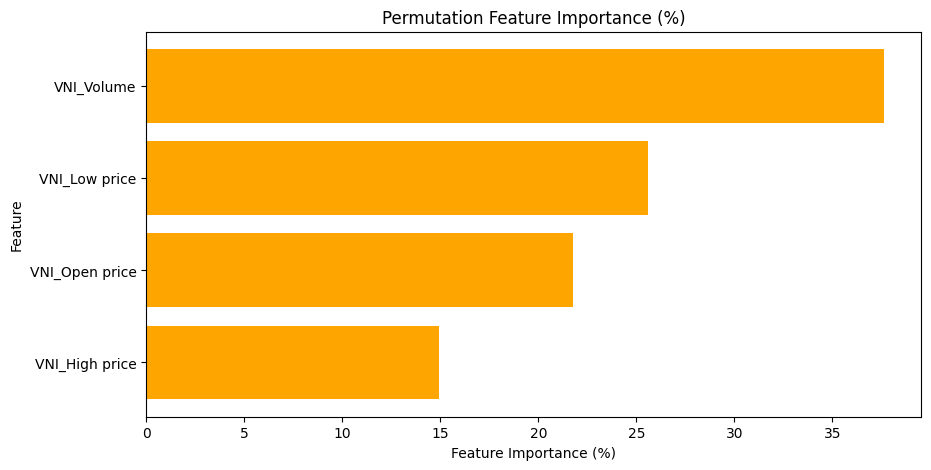

In [7]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_test, y_test, feature_cols, scaler_target):
    baseline_preds = model(X_test.to(device)).cpu().detach().numpy()
    baseline_preds = scaler_target.inverse_transform(baseline_preds.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1))
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importance_scores = {}

    for i, col in enumerate(feature_cols):
        X_test_permuted = X_test.clone()
        permuted_col = X_test_permuted[:, :, i]
        permuted_col[:] = permuted_col[torch.randperm(permuted_col.shape[0])]  # Xáo trộn giá trị cột

        permuted_preds = model(X_test_permuted.to(device)).cpu().detach().numpy()
        permuted_preds = scaler_target.inverse_transform(permuted_preds.reshape(-1, 1))

        permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_preds))
        importance_scores[col] = permuted_rmse - baseline_rmse  # Chênh lệch RMSE

    # Chuyển đổi sang % importance
    total_importance = sum(importance_scores.values())
    importance_percent = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

    return importance_percent

# Chạy tính toán importance
X_test_tensor, y_test_tensor = X_test.to(device), y_test.to(device)
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, feature_cols, scaler_target)
import matplotlib.pyplot as plt

# Sắp xếp feature importance theo giá trị giảm dần
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.barh(features, importance_values, color='orange')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (%)")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất nằm trên cùng
plt.show()


In [26]:
# Kiểm tra số lượng features khi train
print("📌 Số lượng features khi train:", len(feature_cols))
print("📌 Danh sách features khi train:", feature_cols)

# Kiểm tra số lượng features trong OOS
print("📌 Số lượng features khi OOS:", df_oos.shape[1])
print("📌 Danh sách features khi OOS:", df_oos.columns.tolist())


📌 Số lượng features khi train: 4
📌 Danh sách features khi train: ['VNI_Open price', 'VNI_High price', 'VNI_Low price', 'VNI_Volume']
📌 Số lượng features khi OOS: 5
📌 Danh sách features khi OOS: ['VNI_Volume', 'VNI_Close price', 'VNI_Open price', 'VNI_High price', 'VNI_Low price']


In [28]:
print("📌 X_oos.shape:", X_oos.shape)  # Kiểm tra input đầu vào
checkpoint = torch.load("transformer_model.pth", map_location=device)
for key, value in checkpoint.items():
    print(f"{key}: {value.shape}")  # Kiểm tra kích thước trọng số đã lưu


📌 X_oos.shape: torch.Size([57, 10, 5])
embedding.weight: torch.Size([64, 5])
embedding.bias: torch.Size([64])
encoder_layer.self_attn.in_proj_weight: torch.Size([192, 64])
encoder_layer.self_attn.in_proj_bias: torch.Size([192])
encoder_layer.self_attn.out_proj.weight: torch.Size([64, 64])
encoder_layer.self_attn.out_proj.bias: torch.Size([64])
encoder_layer.linear1.weight: torch.Size([2048, 64])
encoder_layer.linear1.bias: torch.Size([2048])
encoder_layer.linear2.weight: torch.Size([64, 2048])
encoder_layer.linear2.bias: torch.Size([64])
encoder_layer.norm1.weight: torch.Size([64])
encoder_layer.norm1.bias: torch.Size([64])
encoder_layer.norm2.weight: torch.Size([64])
encoder_layer.norm2.bias: torch.Size([64])
transformer_encoder.layers.0.self_attn.in_proj_weight: torch.Size([192, 64])
transformer_encoder.layers.0.self_attn.in_proj_bias: torch.Size([192])
transformer_encoder.layers.0.self_attn.out_proj.weight: torch.Size([64, 64])
transformer_encoder.layers.0.self_attn.out_proj.bias: t